# EGFR data curation

**EGFR (Epidermal Growth Factor Receptor) kinase** is a type of receptor tyrosine kinase that plays a significant role in cell growth, proliferation, and survival. Mutations or overexpression of EGFR have been associated with various diseases, particularly cancer.

- **EGFR Wild type**:  Targeting wild-type EGFR with small-molecule inhibitors, such as erlotinib, is an ongoing area of research in the treatment of glioblastoma. While early findings are promising, the complexity of glioblastoma biology presents challenges that require further investigation to improve treatment outcomes for patients.
- **EGFR L858R:** While EGFR TKIs initially demonstrate impressive responses in NSCLC patients with the L858R mutation, resistance to these drugs can develop over time. However, newer generations of EGFR TKIs, like osimertinib, have been developed to target these resistant mutations.

**Published EGFR datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis ([ref](https://pubmed.ncbi.nlm.nih.gov/26501955/)).

**Description of readout:**
- **Readouts**: `EGFR_(L858R_mutant)`, `EGFR`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

<a id="curation"></a>
# EGFR data curation

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
import polaris
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
!gsutil cp "gs://polaris-private/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parque" "gs://polaris-public/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parque"

CommandException: No URLs matched: gs://polaris-private/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parque


In [3]:
# load data
data = pd.read_parquet(
    "gs://polaris-public/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parquet"
)
data.shape

(364, 1129)

In [4]:
# Define data column names
data_cols = ['EGFR_(L858R_mutant)', 'EGFR']
mol_col = "smiles"
data = data[[mol_col] + data_cols][data[data_cols].notna().any(axis=1)]

In [5]:
data.describe()[data_cols]

,EGFR_(L858R_mutant),EGFR
count,364.000000,363.000000
mean,19.391113,16.777479
std,27.327321,26.539644
min,-5.940000,-20.030000
25%,2.610000,2.605000
50%,6.525000,5.590000
75%,22.255000,11.875000
max,101.510000,98.050000


In [6]:
for data_col in data_cols: 
    display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_25481/1691884317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())


EGFR_(L858R_mutant)
(0, 70]      293
(70, 75]       6
(75, 80]       5
(80, 90]      11
(90, 100]     15
Name: EGFR_(L858R_mutant), dtype: int64

EGFR
(0, 70]      303
(70, 75]       3
(75, 80]      15
(80, 90]      19
(90, 100]      6
Name: EGFR, dtype: int64

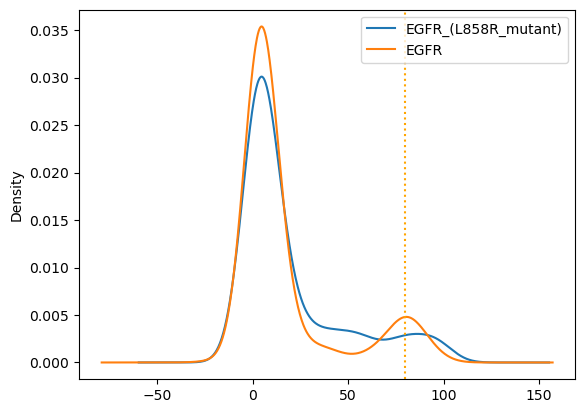

In [13]:
fig = data[data_cols].plot.kde()
plt.axvline(x=80, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [14]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
# However, due to the number of active compounds and the above distribution
# We can lower the threshold to 80
th = 80
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [9]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

2023-10-29 21:40:55.125 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR_(L858R_mutant) using zscore. Please revise the data and consider remove the outliers. 
2023-10-29 21:40:55.127 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 1 outliers for data column EGFR using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future 

In [10]:
for col in data_cols:
    print(col)
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

EGFR_(L858R_mutant)


,EGFR_(L858R_mutant),EGFR
146,101.51,78.07


EGFR


,EGFR_(L858R_mutant),EGFR
33,80.97,98.05


The curation raised warning for potential outliers from the bioactivity readouts of all EGFR mutants. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

[<Figure size 1600x400 with 2 Axes>, <Figure size 1600x400 with 2 Axes>]

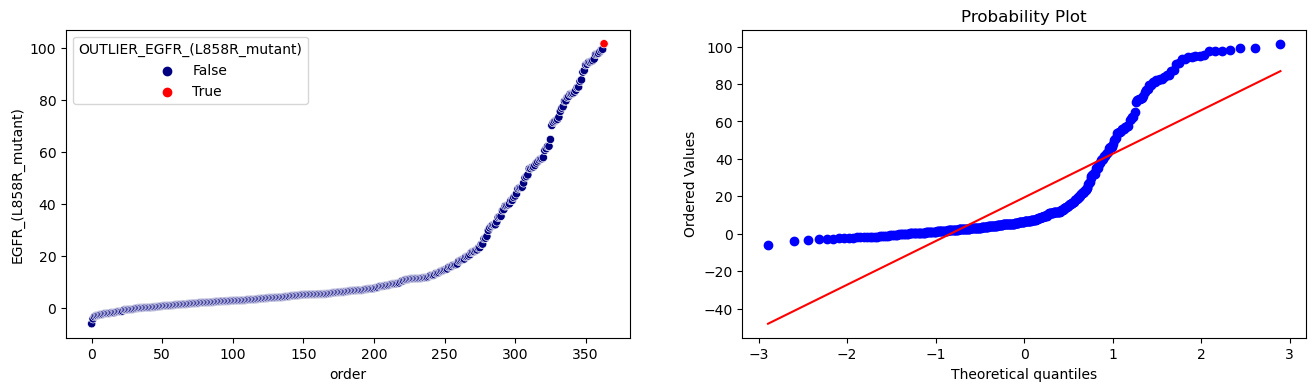

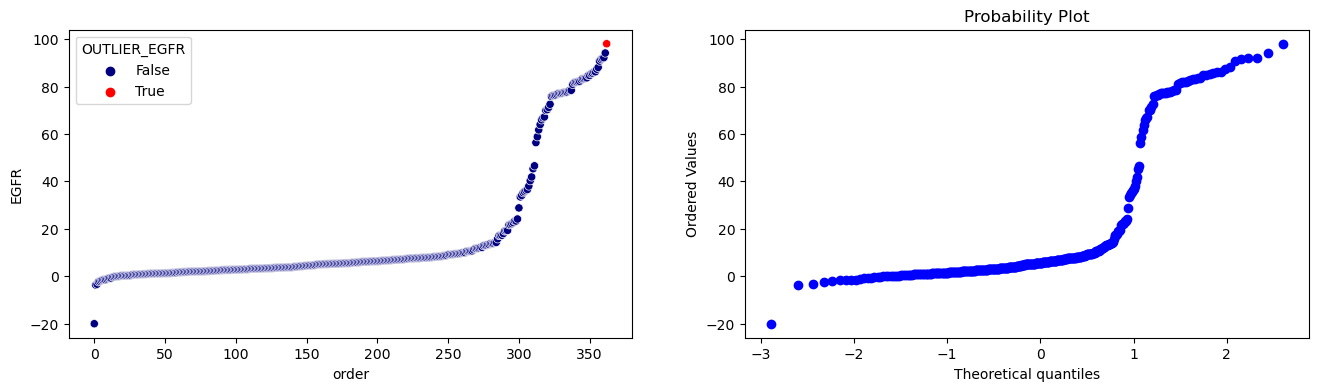

In [11]:
from polaris.curation.viz_utils import visulize_distribution
visulize_distribution(dataset=df_full, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Export curated data

In [12]:
df_full.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)
df_full.to_parquet( "gs://polaris-public/Data/Kinases/EGFR_mutants_curated.parquet", index=False)